In [2]:
import akshare as ak
import pandas as pd
import os
import numpy as np
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

In [3]:
#获取数据
code = "600519"  #茅台
df = ak.stock_zh_a_hist(
    symbol=code,
    adjust="qfq")
df = df.rename(columns={
    "日期": "date",
    "股票代码": "code",
    "开盘": "open",
    "收盘": "close",
    "最高": "high",
    "最低": "low",
    "成交量": "volume",
    "成交额": "amount",
    "振幅": "amplitude",
    "涨跌幅": "pct_chg",
    "涨跌额": "chg",
    "换手率": "turnover"
})

df["date"] = pd.to_datetime(df["date"])
df = df.sort_values("date")
df.reset_index(drop=True, inplace=True)
print(df.head())
os.makedirs("data", exist_ok=True)
df.to_csv("data/600519_clean.csv", index=False)

        date    code    open   close    high     low  volume        amount  \
0 2001-08-27  600519 -260.70 -260.49 -260.04 -261.03  406318  1.410347e+09   
1 2001-08-28  600519 -260.60 -260.23 -260.20 -260.68  129647  4.634630e+08   
2 2001-08-29  600519 -260.20 -260.32 -260.20 -260.38   53252  1.946890e+08   
3 2001-08-30  600519 -260.34 -260.18 -260.10 -260.40   48013  1.775580e+08   
4 2001-08-31  600519 -260.17 -260.20 -260.08 -260.24   23231  8.623100e+07   

   amplitude  pct_chg   chg  turnover  
0      -0.38     0.32  0.83     56.83  
1      -0.18     0.10  0.26     18.13  
2      -0.07    -0.03 -0.09      7.45  
3      -0.12     0.05  0.14      6.72  
4      -0.06    -0.01 -0.02      3.25  


In [4]:
#特征工程1---baseline
def add_features(df):
    df = df.copy()

    # MA
    df['ma5'] = df['close'].rolling(5).mean()
    df['ma10'] = df['close'].rolling(10).mean()
    df['ma20'] = df['close'].rolling(20).mean()

    # MOM
    df['mom5']  = df['close'] - df['close'].shift(5)    
    df['mom10'] = df['close'] - df['close'].shift(10)   
    df['mom20'] = df['close'] - df['close'].shift(20) 

    # Volatility
    df['volatility10'] = df['close'].rolling(10).std()

    # RSI
    delta = df['close'].diff()
    up = delta.clip(lower=0)
    down = -delta.clip(upper=0)

    roll_up = up.rolling(14).mean()
    roll_down = down.rolling(14).mean()
    df['rsi14'] = roll_up / (roll_up + roll_down)

    # MACD
    df['ema12'] = df['close'].ewm(span=12, adjust=False).mean()
    df['ema26'] = df['close'].ewm(span=26, adjust=False).mean()
    df['diff'] = df['ema12'] - df['ema26']
    df['dea'] = df['diff'].ewm(span=9, adjust=False).mean()
    df['macd'] = 2 * (df['diff'] - df['dea'])
    
    return df
df = add_features(df)
df.tail()
print(df.tail())
df = df.dropna().reset_index(drop=True)

           date    code     open    close     high      low  volume  \
5811 2025-12-01  600519  1451.00  1448.00  1462.27  1442.00   27333   
5812 2025-12-02  600519  1448.00  1436.03  1451.92  1435.02   25047   
5813 2025-12-03  600519  1435.81  1429.10  1435.97  1428.00   23573   
5814 2025-12-04  600519  1429.10  1423.98  1432.50  1418.38   29075   
5815 2025-12-05  600519  1423.98  1430.01  1433.09  1419.50   25402   

            amount  amplitude  pct_chg  ...   mom5  mom10  mom20  \
5811  3.961995e+09       1.40    -0.17  ...  -4.00 -23.00  13.00   
5812  3.607544e+09       1.17    -0.83  ...  -8.62 -39.97   7.03   
5813  3.370080e+09       0.56    -0.48  ... -20.05 -41.91   9.02   
5814  4.134922e+09       0.99    -0.36  ... -23.32 -43.13 -11.15   
5815  3.622682e+09       0.95     0.42  ... -20.49 -36.59  -3.32   

      volatility10     rsi14        ema12        ema26      diff       dea  \
5811     11.583508  0.437536  1453.391753  1453.684128 -0.292375  1.172686   
5812    

In [5]:
#目标变量
##未来一天的收益
df['ret_1d'] = df['close'].pct_change().shift(-1)
##未来5天的收益
df['ret_5d'] = (df['close'].shift(-5) - df['close']) / df['close']
##未来涨跌【二分类】
df['label_updown'] = (df['ret_1d'] > 0).astype(int) 
##未来5天是否涨超过2%
df['label_5d_gt2'] = (df['ret_5d'] > 0.02).astype(int)
df = df.dropna().reset_index(drop=True)

In [6]:
#数据处理
df = df[df['close'] > 0].copy()
df['close'] = df['close'].replace([np.inf, -np.inf], np.nan)
df = df.dropna(subset=['close'])
df['ret_1d'] = df['close'].pct_change().shift(-1)
df['ret_1d'] = df['ret_1d'].replace([np.inf, -np.inf], np.nan)
df = df[(df['ret_1d'] > -0.2) & (df['ret_1d'] < 0.2)]
df = df.dropna(subset=['ret_1d']).reset_index(drop=True)
df['ret_1d'].describe()

count    2307.000000
mean        0.001871
std         0.028589
min        -0.157129
25%        -0.011028
50%        -0.000207
75%         0.012966
max         0.182709
Name: ret_1d, dtype: float64

In [7]:
#模型训练---XGBoost
feature_cols = [
    'ma5', 'ma10', 'ma20',
    'mom5', 'mom10', 'mom20',
    'volatility10',
    'rsi14',
    'diff', 'dea', 'macd'
]

X = df[feature_cols]  
y = df['ret_1d']   
split_ratio = 0.8
split = int(len(df) * split_ratio)
X_train, X_test = X.iloc[:split], X.iloc[split:]
y_train, y_test = y.iloc[:split], y.iloc[split:]
##训练集训练
model = XGBRegressor(
    n_estimators=300,      
    max_depth=5,           
    learning_rate=0.05,   
    subsample=0.8,        
    colsample_bytree=0.8  
)
model.fit(X_train, y_train)
##测试集预测
y_pred = model.predict(X_test)

In [8]:
#结果
mse = mean_squared_error(y_test, y_pred)
print(mse)

0.0002665730028298222


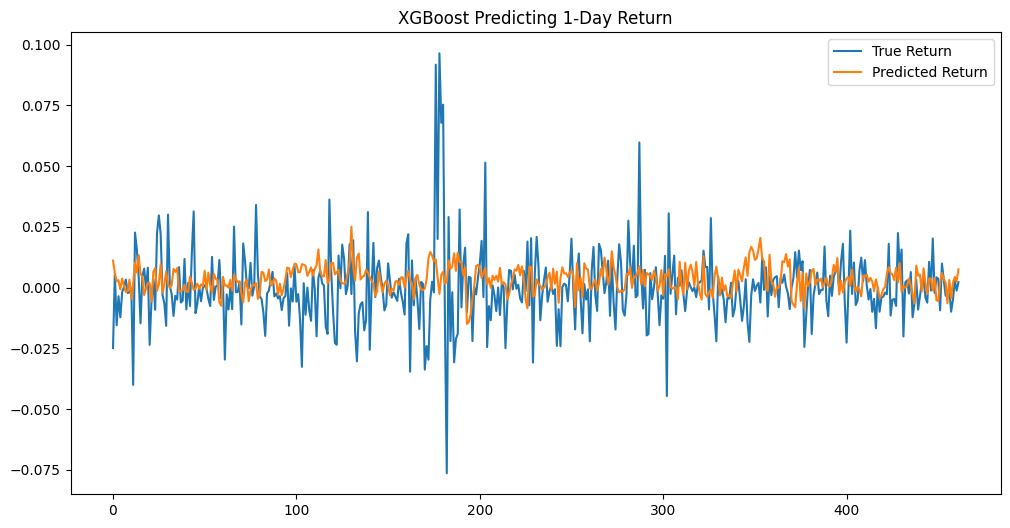

In [9]:
#可视化
plt.figure(figsize=(12,6))
plt.plot(y_test.values, label='True Return')
plt.plot(y_pred, label='Predicted Return')
plt.legend()
plt.title("XGBoost Predicting 1-Day Return")
plt.show()

In [10]:
#特征重要性
importances = model.feature_importances_
sorted_importances = sorted(zip(feature_cols, importances), key=lambda x: x[1], reverse=True)
print(sorted_importances)

[('dea', np.float32(0.10345684)), ('volatility10', np.float32(0.09839122)), ('mom10', np.float32(0.09664269)), ('mom20', np.float32(0.095434)), ('macd', np.float32(0.09014117)), ('ma20', np.float32(0.089539774)), ('diff', np.float32(0.08712434)), ('rsi14', np.float32(0.08604243)), ('ma10', np.float32(0.08513914)), ('mom5', np.float32(0.08427534)), ('ma5', np.float32(0.083813146))]


In [11]:
#强化:加入新的特征工程

##EMA指数移动平均
def add_ema(df, windows=[5, 10, 20]):
    for w in windows:
        df[f'ema{w}'] = df['close'].ewm(span=w, adjust=False).mean()
    return df

df = add_ema(df)
##布林带
def add_bollinger(df, window=20):
    ma = df['close'].rolling(window).mean()
    std = df['close'].rolling(window).std()

    df['boll_middle'] = ma
    df['boll_upper'] = ma + 2 * std
    df['boll_lower'] = ma - 2 * std
    df['boll_width'] = (df['boll_upper'] - df['boll_lower']) / ma  
    return df

df = add_bollinger(df)
##ATR真实波动范围
def add_atr(df, window=14):
    df['h_l'] = df['high'] - df['low']
    df['h_pc'] = abs(df['high'] - df['close'].shift(1))
    df['l_pc'] = abs(df['low'] - df['close'].shift(1))

    tr = df[['h_l', 'h_pc', 'l_pc']].max(axis=1)
    df['atr'] = tr.rolling(window).mean()

    df.drop(['h_l', 'h_pc', 'l_pc'], axis=1, inplace=True)
    return df

df = add_atr(df)
df = df.dropna().reset_index(drop=True)
##新构建的特征
feature_cols = [
    # 原有特征
    'ma5', 'ma10', 'ma20',
    'mom5', 'mom10', 'mom20',
    'volatility10',
    'rsi14',
    'macd', 'diff', 'dea',
    # 新增特征（EMA）
    'ema5', 'ema10', 'ema20',
    # 新增特征（Bollinger）
    'boll_middle', 'boll_upper', 'boll_lower', 'boll_width',
    # 新增特征（ATR）
    'atr',]

#模型训练
X = df[feature_cols]
y = df['ret_1d']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False)
model = XGBRegressor(
    n_estimators=300,
    max_depth=5,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
)

model.fit(X_train, y_train)
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(mse)

#特征重要性
sorted_importances = sorted(
    zip(feature_cols, model.feature_importances_),
    key=lambda x: x[1],
    reverse=True)
print(sorted_importances)

0.0002622228852533449
[('ema20', np.float32(0.07763475)), ('ema5', np.float32(0.07702731)), ('ema10', np.float32(0.07673458)), ('boll_lower', np.float32(0.06449655)), ('boll_upper', np.float32(0.055858072)), ('dea', np.float32(0.05525368)), ('atr', np.float32(0.052458305)), ('boll_width', np.float32(0.05099844)), ('volatility10', np.float32(0.050757412)), ('macd', np.float32(0.049606692)), ('diff', np.float32(0.049084473)), ('boll_middle', np.float32(0.046985235)), ('mom10', np.float32(0.046452496)), ('mom20', np.float32(0.043816205)), ('rsi14', np.float32(0.042827293)), ('ma20', np.float32(0.04186051)), ('ma5', np.float32(0.04108175)), ('ma10', np.float32(0.039111268)), ('mom5', np.float32(0.037954975))]


0.000260093329391934
[('ema20', np.float32(0.11193506)), ('ema10', np.float32(0.10660796)), ('ma20', np.float32(0.0984473)), ('mom10', np.float32(0.08871182)), ('boll_width', np.float32(0.0840725)), ('volatility10', np.float32(0.082679816)), ('rsi14', np.float32(0.079999864)), ('dea', np.float32(0.078935534)), ('mom20', np.float32(0.077713)), ('mom5', np.float32(0.06990633)), ('diff', np.float32(0.06604168)), ('macd', np.float32(0.054949198))]


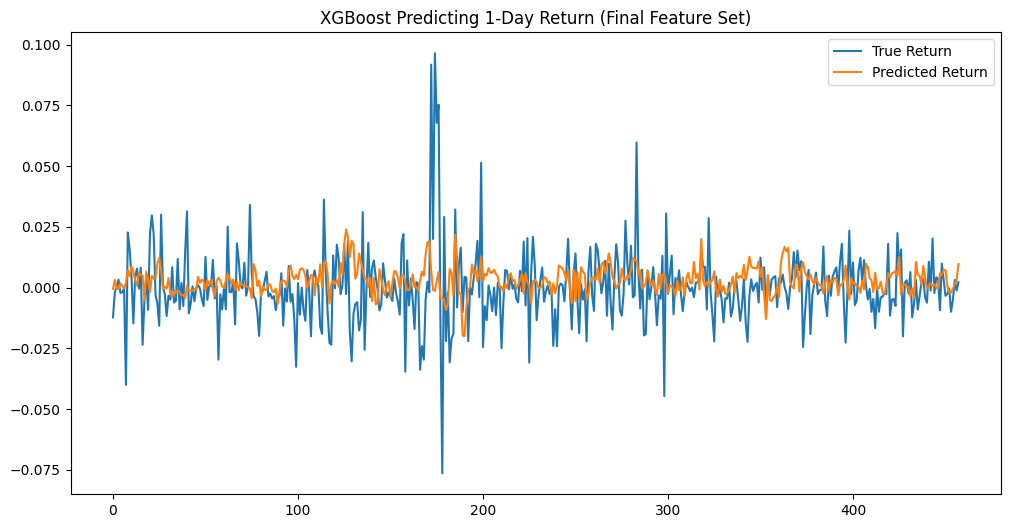

In [12]:
#优化

feature_cols = [
    # 趋势类（最重要）
    'macd', 'diff', 'dea',

    # 动量类（有效）
    'mom5', 'mom10', 'mom20',

    # 波动类（有效）
    'volatility10', 'boll_width',

    # EMA（保留敏感度最好的两个）
    'ema10', 'ema20',

    # 超买超卖
    'rsi14',

    # 中期均线（只保留 ma20）
    'ma20',]

X = df[feature_cols]
y = df['ret_1d']


X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False)

model = XGBRegressor(
    n_estimators=300,
    max_depth=5,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,)

model.fit(X_train, y_train)
y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
print(mse)

sorted_importances = sorted(
    zip(feature_cols, model.feature_importances_),
    key=lambda x: x[1],
    reverse=True
)
print(sorted_importances)

plt.figure(figsize=(12,6))
plt.plot(y_test.values, label='True Return')
plt.plot(y_pred, label='Predicted Return')
plt.legend()
plt.title("XGBoost Predicting 1-Day Return (Final Feature Set)")
plt.savefig("pred_vs_true.png", dpi=300)
plt.show()